In [3]:
# Import libraries/packages
import pandas as pd
import googlemaps, polyline
import matplotlib.pyplot as plt

In [4]:
# Load original dataset
df = pd.read_csv('https://github.com/Marius-14/thesis_code/blob/bd0ff6424691ab4df91e3717cc130e338b64c035/data/raw/fuel_data_raw.csv?raw=true')

In [ ]:
gmaps = googlemaps.Client(key="")

pairs = (
    df[["Origin_ID", "Origin_Latitude", "Origin_Longitude",
        "Destination_ID", "Destination_Latitude", "Destination_Longitude"]]
    .drop_duplicates()
)


In [ ]:
route_cache = {}

def fetch_route(row):
    o = (row.Origin_Latitude, row.Origin_Longitude)
    d = (row.Destination_Latitude, row.Destination_Longitude)
    key = (o, d)
    if key not in route_cache:
        r = gmaps.directions(o, d, mode="driving", alternatives=False)
        poly = r[0]["overview_polyline"]["points"]
        route_cache[key] = polyline.decode(poly)
    return route_cache[key]

pairs["geometry"] = pairs.apply(fetch_route, axis=1)


In [7]:
# Find a reference corner and translate everything relative to it
all_lats = [lat for geom in pairs.geometry for lat, _ in geom]
all_lons = [lon for geom in pairs.geometry for _, lon in geom]
lat0, lon0 = min(all_lats), min(all_lons)

def shift_geom(geom):
    return [(lat - lat0, lon - lon0) for lat, lon in geom]

pairs["shifted"] = pairs.geometry.apply(shift_geom)


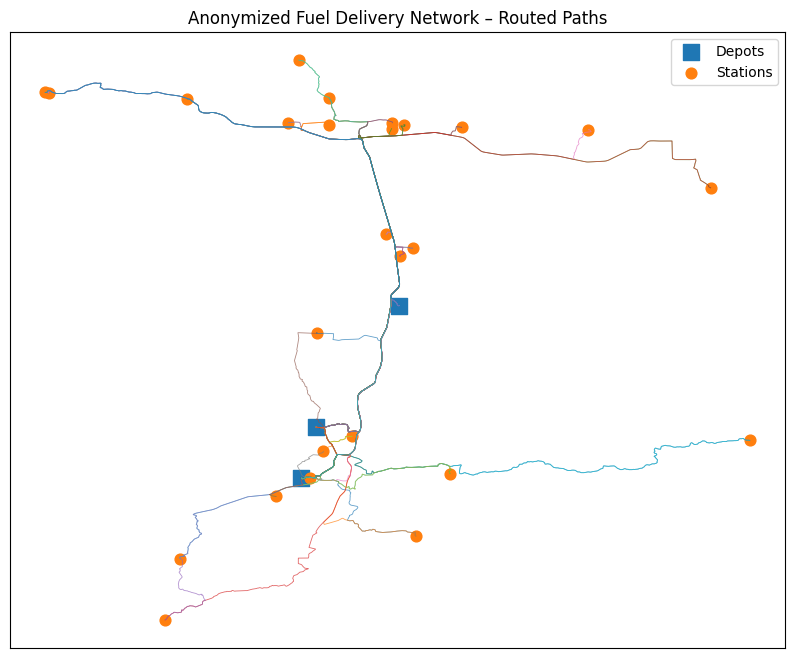

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))

# Draw every shifted polyline
for route in pairs.shifted:
    xs, ys = zip(*[(lon, lat) for lat, lon in route])
    ax.plot(xs, ys, linewidth=0.6, alpha=0.7)

# Depots
origins = (
    pairs.groupby("Origin_ID")["shifted"]
         .apply(lambda g: g.iloc[0][0]) 
         .apply(pd.Series)
         .rename(columns={0: "Shifted_Oy", 1: "Shifted_Ox"})
         .reset_index()
)
ax.scatter(origins["Shifted_Ox"], origins["Shifted_Oy"], marker="s", s=120, label="Depots")

# Stations
destinations = (
    pairs.groupby("Destination_ID")["shifted"]
         .apply(lambda g: g.iloc[0][-1])
         .apply(pd.Series)
         .rename(columns={0: "Shifted_Dy", 1: "Shifted_Dx"})
         .reset_index()
)
ax.scatter(destinations["Shifted_Dx"], destinations["Shifted_Dy"], marker="o", s=60, label="Stations")

# Remove geographic context
ax.set_xticks([]); ax.set_yticks([])
ax.set_xlabel(""); ax.set_ylabel("")
ax.set_title("Anonymized Fuel Delivery Network – Routed Paths")
ax.legend()
plt.show()
